In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
from plotnine import *
import itertools


project_dir = str(Path(os.getcwd()).parent)
datasets_path = str(Path(os.getcwd()).parent) + "/datasets/"
df = pd.read_csv(datasets_path + "down_detector_outage_count.csv")
df_2018 = pd.read_parquet(datasets_path + "2018_fixed_sesaeet.parquet")
df_2019 = pd.read_parquet(datasets_path + "2019_fixed_sesaeet.parquet")
df_2020 = pd.read_parquet(datasets_path + "2020_fixed_sesaeet.parquet") # When 2020 is cleaned and ready
# df_vendor = df_2019.append(df_2018).sort_values("event_start_time", inplace=False).reset_index(inplace=False, drop=True)
df_vendor = df_2020#.append(df_vendor).sort_values("event_start_time", inplace=False).reset_index(inplace=False, drop=True)

In [2]:
df_vendor.groupby("event_start_time", )["service_id"].count().reset_index().sort_values("service_id")

,event_start_time,service_id
0,2020-01-07 14:35:48,1
1,2020-01-08 08:05:00,1
3,2020-01-15 03:49:00,1
4,2020-01-16 07:05:00,1
7,2020-01-18 00:11:00,1
...,...,...
201,2020-10-06 13:45:00,2
237,2020-11-25 21:15:00,2
253,2020-12-18 03:30:00,3
234,2020-11-24 21:15:00,7


In [3]:

def extract_failure_event_times(partial_df):
    start_time = None
    end_time = None
    num_reports_list = []
    failure_events = []
    page_ids = partial_df.sort_values("timestamp")['event_id'].unique()

    q_val = 0.75
    # Extract event_start and event_end from each event
    event_id = 0
    for page_id in page_ids:
        df_page = partial_df[partial_df["event_id"] == page_id].sort_values("timestamp")
        threshold = df_page["count"].quantile(q_val) 
        while threshold == 0:
            q_val += 0.05
            threshold = df_page["count"].quantile(q_val)
        
        for i, page in df_page.sort_values("timestamp").iterrows():
            nr_reports = page['count']
            event_time = page['timestamp']
            vendor = page['provider']

            if nr_reports > threshold:
                if start_time == None:
                    start_time = event_time

                num_reports_list.append(nr_reports)

            else:
                if start_time != None:
                    end_time = event_time
                    if 900 * 95 > end_time - start_time > 0: # If duration is longer than 23:45, don't add it.
                        failure_events.append({
                            'start_time': start_time,
                            'end_time': end_time,
                            'duration': end_time-start_time,
                            'peak': np.max(num_reports_list),
                            'threshold': threshold,
                            'median': np.median(num_reports_list),
                            'mean': np.mean(num_reports_list),
                            'page_id': page_id,
                            'event_id': event_id,
                            'vendor': vendor
                        })
                        event_id += 1
                        
                    start_time = None
                    end_time = None
                    num_reports_list = []
                    
    return pd.DataFrame(failure_events)

In [59]:
df_user.groupby("start_datetime").count().reset_index().sort_values("event_id")

,start_datetime,start_time,end_time,duration,peak,threshold,median,mean,page_id,event_id,vendor,start_date
0,2020-02-05 15:30:51,1,1,1,1,1,1,1,1,1,1,1
234,2020-10-07 23:04:06,1,1,1,1,1,1,1,1,1,1,1
233,2020-10-07 22:34:06,1,1,1,1,1,1,1,1,1,1,1
232,2020-10-07 18:19:06,1,1,1,1,1,1,1,1,1,1,1
231,2020-10-07 16:49:06,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
112,2020-07-18 02:24:09,1,1,1,1,1,1,1,1,1,1,1
111,2020-07-17 22:54:09,1,1,1,1,1,1,1,1,1,1,1
110,2020-07-17 22:22:08,1,1,1,1,1,1,1,1,1,1,1
118,2020-07-18 13:22:08,1,1,1,1,1,1,1,1,1,1,1


In [76]:
df_user = extract_failure_event_times(df)

df_user["start_datetime"] = pd.to_datetime(df_user["start_time"], unit="s")
df_user["end_datetime"] = pd.to_datetime(df_user["end_time"], unit="s")
df_user["start_date"] = df_user["start_datetime"].dt.date
df_user["start_time"] = df_user["start_datetime"].dt.time

df_user["start_time"] = df_user["start_time"].astype(str)
df_user["start_date"] = df_user["start_date"].astype(str)
df_user = df_user.loc[df_user["start_datetime"].dt.year == 2020, :].reset_index(drop=True)

df_vendor["event_start_date"] = df_vendor["event_start_time"].dt.date 
df_vendor["event_time_only"] = df_vendor["event_start_time"].dt.time 

df_vendor["event_start_date"] = df_vendor["event_start_date"].astype(str)
df_vendor["event_time_only"] = df_vendor["event_time_only"].astype(str)

In [77]:
aws_user = df_user[df_user["vendor"]=="aws"].reset_index(drop=True)
aws_vendor = df_vendor[df_vendor["vendor"]=="AWS"].reset_index(drop=True)
aws_user["event_start_time"] = aws_user["start_datetime"]
aws_user["event_end_time"] = aws_user["end_datetime"]

In [99]:
def make_grid(df):
    # First make and populate 2D grid array
    grid_array = np.full((365, 24), 0)
    for _, row in df.sort_values('event_start_time').iterrows():
        year_of_event = row['event_start_time'].year
        start_day_of_year = row['event_start_time'].timetuple().tm_yday
        start_hour_of_day = row['event_start_time'].hour
        end_day_of_year = row['event_end_time'].timetuple().tm_yday
        end_hour_of_day = row['event_end_time'].hour
        
        offset = 0
        # if year_of_event == 2019:
        #     offset = 0
        # elif year_of_event == 2020:
        #     offset = 365
        # else:
        #     raise Exception('Unknown year: ' + str(year_of_event))
        
        if start_day_of_year == end_day_of_year: # less than a day
            # if row["status"] == "major":
            #     print(row, start_hour_of_day, end_hour_of_day)
            for hour_of_day in range(start_hour_of_day, end_hour_of_day+1):
                grid_array[offset+start_day_of_year-1, hour_of_day-1] = grid_array[offset+start_day_of_year-1, hour_of_day-1]+1
        else:
            for day_of_year in range(start_day_of_year, end_day_of_year+1):
                if day_of_year == start_day_of_year: # first day
                    for hour_of_day in range(start_hour_of_day, 25):
                        grid_array[offset+day_of_year-1, hour_of_day-1] = grid_array[offset+start_day_of_year-1, hour_of_day-1]+1
                elif day_of_year == end_day_of_year: # last day
                    for hour_of_day in range(0, end_hour_of_day):
                        grid_array[offset+day_of_year-1, hour_of_day-1] = grid_array[offset+start_day_of_year-1, hour_of_day-1]+1
                else: # middle day
                    for hour_of_day in range(1, 25):
                        grid_array[offset+day_of_year-1, hour_of_day-1] = grid_array[offset+start_day_of_year-1, hour_of_day-1]+1
        
    return grid_array

user_grid_array = make_grid(aws_user)
user_grid_df = pd.DataFrame({
    'day_of_year': np.repeat(np.arange(1, 365+1), 24),
    'hour_of_day': np.tile(np.arange(1, 24+1), 365),
    'year': np.repeat(2020, 365*24),
    'status': user_grid_array.flatten()
})
user_grid_df.loc[user_grid_df["status"] >= 1, "status"] = 1

vendor_grid_array = make_grid(aws_vendor)
vendor_grid_df = pd.DataFrame({
    'day_of_year': np.repeat(np.arange(1, 365+1), 24),
    'hour_of_day': np.tile(np.arange(1, 24+1), 365),
    'year': np.repeat(2020, 365*24),
    'status': vendor_grid_array.flatten()
})
vendor_grid_df.loc[(vendor_grid_df["status"] >= 1) & (vendor_grid_df["status"] <= 3), "status"] = 1
vendor_grid_df.loc[vendor_grid_df["status"] > 3, "status"] = 2

vendor_grid_df

,day_of_year,hour_of_day,year,status
0,1,1,2020,0
1,1,2,2020,0
2,1,3,2020,0
3,1,4,2020,0
4,1,5,2020,0
...,...,...,...,...
8755,365,20,2020,0
8756,365,21,2020,0
8757,365,22,2020,0
8758,365,23,2020,0


In [100]:
def merge_dfs(github_df, github_or_df):
    list_of_merged_rows = []
    for i in range(github_df.shape[0]):
        github_status = github_df.loc[i, 'status']
        or_github_status = github_or_df.loc[i, 'status']

        final_status = github_status

        if or_github_status == 1:
            if github_status == 0:
                final_status = 3
            elif github_status == 1:
                final_status = 4
            elif github_status == 2:
                final_status = 5
            else:
                raise Exception('Unknown github status')

        list_of_merged_rows.append({
            'status': final_status,
            'hour_of_day': github_df.loc[i, 'hour_of_day'],
            'year': github_df.loc[i, 'year'],
            'day_of_year': github_df.loc[i, 'day_of_year']
        })

    merged_df = pd.DataFrame(list_of_merged_rows)
    #merged_df['status'] = pd.Categorical(merged_df['status'], [0,1,2,3,4,5,6,7], ordered=True) # When maintenance overlap is there
    merged_df['status'] = pd.Categorical(merged_df['status'], [0,1,2,3,4,5], ordered=True)
    return merged_df

merged_df = merge_dfs(vendor_grid_df, user_grid_df)

In [101]:
merged_df

,status,hour_of_day,year,day_of_year
0,0,1,2020,1
1,0,2,2020,1
2,0,3,2020,1
3,0,4,2020,1
4,0,5,2020,1
...,...,...,...,...
8755,0,20,2020,365
8756,0,21,2020,365
8757,0,22,2020,365
8758,0,23,2020,365


In [110]:
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
first_day_of_month = list(itertools.accumulate(days_per_month, initial=1))
first_day_of_month

[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366]

/home/stalluri/.miniconda3/envs/thesis/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 2 in image.
/home/stalluri/.miniconda3/envs/thesis/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/stalluri/cfa/mehmet-cloud-failure-characterization/down-detector/plots/aws_merged_failures.pdf


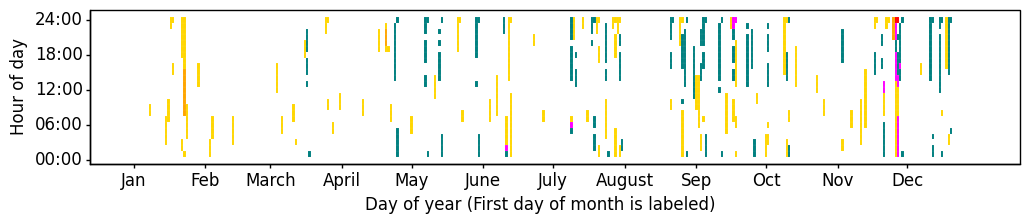

<ggplot: (8778804063293)>

In [111]:
plt = (ggplot(merged_df.loc[merged_df["year"] == 2020, :]) +
    theme_classic(base_size=12, base_family='sans-serif') +
    geom_tile(mapping=aes(x='day_of_year', y='hour_of_day', fill='status'), color='white', size=0.02) +
    scale_fill_manual(values=['white', 'gold', 'orange', 'teal', 'magenta', 'red'],
                      labels=['None', 'Minor', 'Major', 'Report without Overlap', 'Report overlaps Minor', 'Report overlaps Major']) +
    scale_y_continuous(breaks=[0, 6, 12, 18, 24],
                       labels=['00:00', '06:00', '12:00', '18:00', '24:00']) +
    scale_x_continuous(breaks=first_day_of_month[:-1],
                       labels=["Jan","Feb","March","April","May","June","July","August","Sep","Oct","Nov","Dec"]) +
    theme(figure_size=(12, 2)) +
    # guides(fill=guide_legend(title='1 box=1 hour', nrow=1)) +
    guides(fill=None) +
    ylab('Hour of day') +
    xlab('Day of year (First day of month is labeled)') +
    theme(legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_entry_spacing=5,
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          legend_position='top',
          text=element_text(size=12, color="black"),
          panel_border=element_rect(color="black", size=1)))

plt.save(project_dir + "/plots/aws_merged_failures.pdf", limitsize=False)
plt

/tmp/ipykernel_65347/3399131786.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


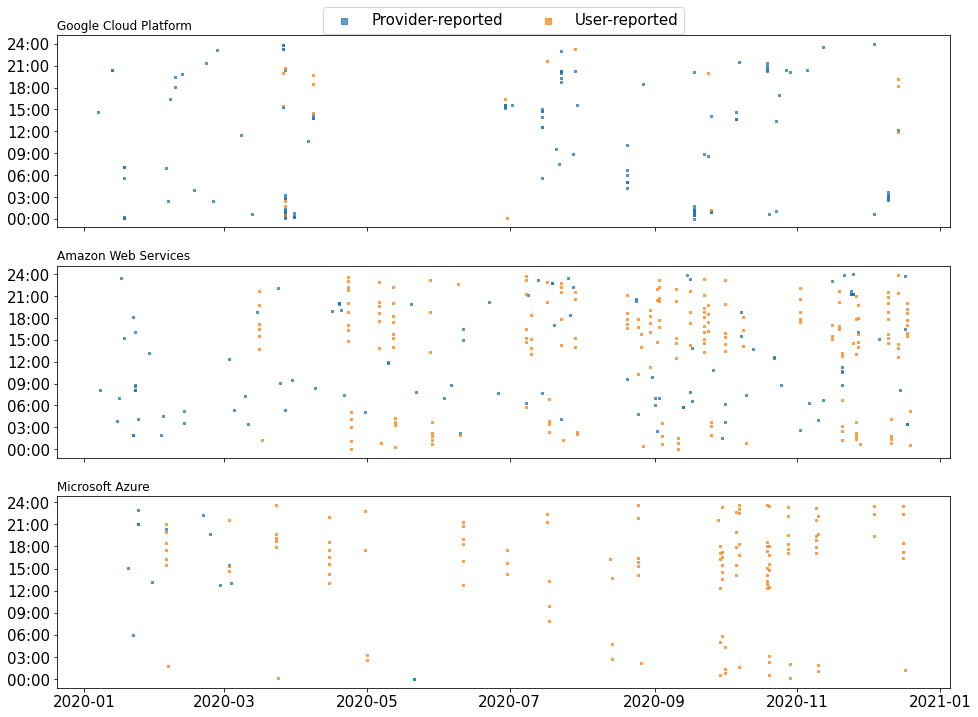

In [22]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(3, 1, figsize=(16,12), sharex=True)

vendor_map = {
    'AWS': 'Amazon Web Services',
    "Azure": 'Microsoft Azure',
    'GCP': 'Google Cloud Platform'
}
for i, vendor in enumerate(df_vendor['vendor'].unique()):
    x_v = mdates.datestr2num(df_vendor[df_vendor['vendor']==vendor]["event_start_date"].values)
    y_v = mdates.datestr2num(df_vendor[df_vendor['vendor']==vendor]["event_time_only"].values)
    x_u = mdates.datestr2num(df_user[df_user['vendor']==vendor.lower()]["start_date"].values)
    y_u = mdates.datestr2num(df_user[df_user['vendor']==vendor.lower()]["start_time"].values)
    
    ax[i].set_title(vendor_map[vendor], loc='left')
    ax[i].scatter(x_v, y_v, s=4, label='Provider-reported', marker='s', alpha=0.7)
    ax[i].scatter(x_u, y_u, s=4, label='User-reported', marker='s', alpha=0.7)
    ax[i].yaxis_date()
    ax[i].xaxis_date()
    labels = [item.get_text() for item in ax[i].get_yticklabels()]
    labels = ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00', '24:00']
    ax[i].set_yticklabels(labels)

    ax[i].tick_params(axis='both', labelsize=15)
    ax[0].legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.08), fontsize=15, markerscale=3)

plt.savefig(project_dir + "/plots/vendors_failure_comparison.pdf", dpi=100)
    
# ytickformat('%.2f')

<ipython-input-6-6ef2b9893de3>:18: UserWarning: FixedFormatter should only be used together with FixedLocator


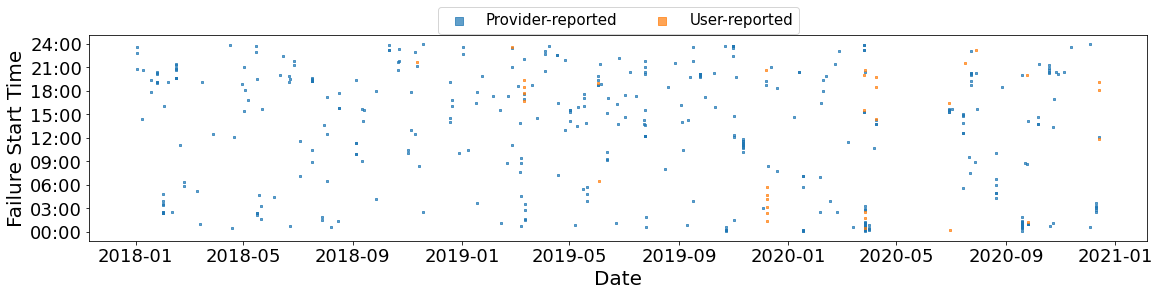

In [6]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, 1, figsize=(16, 4), constrained_layout=True)
x_v = mdates.datestr2num(df_vendor[df_vendor['vendor']=='GCP']["event_start_date"].values)
y_v = mdates.datestr2num(df_vendor[df_vendor['vendor']=='GCP']["event_time_only"].values)
x_u = mdates.datestr2num(df_user[df_user['vendor']=='gcp']["start_date"].values)
y_u = mdates.datestr2num([df_user[df_user['vendor']=='gcp']["start_time"].values])


ax.scatter(x_v, y_v, s=8.5, label='Provider-reported', marker='s', alpha=0.7)
ax.scatter(x_u, y_u, s=8.5, label='User-reported', marker='s', alpha=0.7)
ax.set_ylabel("Failure Start Time", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.yaxis_date()
ax.xaxis_date()
labels = [item.get_text() for item in ax.get_yticklabels()]
labels = ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00', '24:00']
ax.set_yticklabels(labels)

ax.tick_params(axis='both', labelsize=18)
ax.legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.07), fontsize=15, markerscale=3)

plt.savefig(project_dir + "/plots/gcp_failure_comparison.pdf", dpi=100)

/tmp/ipykernel_65347/2532062664.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator


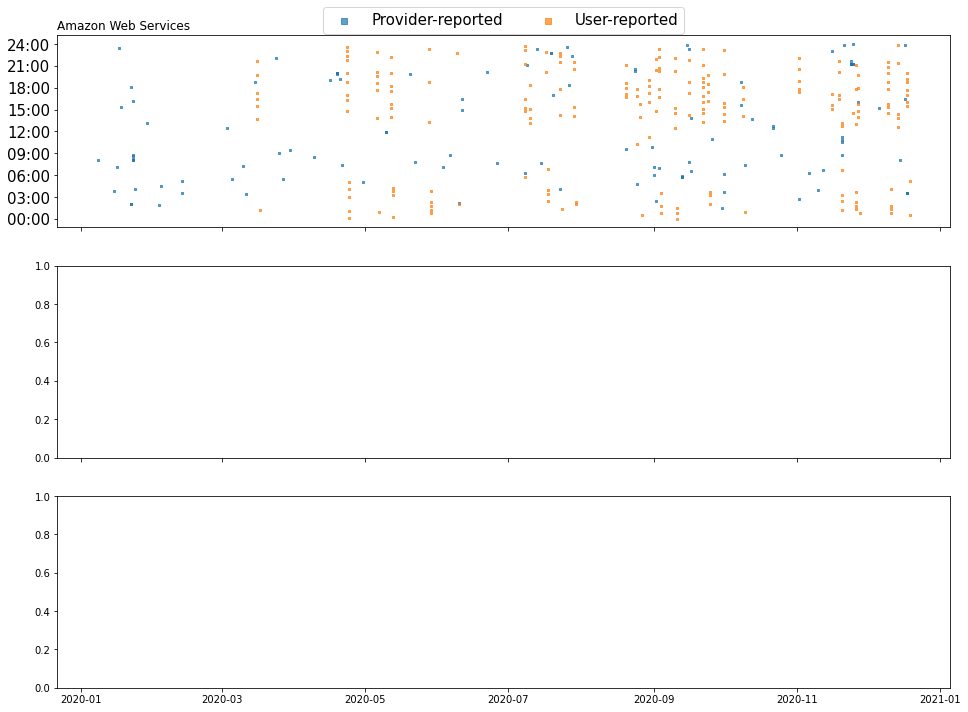

In [34]:
fig, ax = plt.subplots(3, 1, figsize=(16,12), sharex=True)

for i, vendor in enumerate(["AWS"]):
    x_v = mdates.datestr2num(df_vendor[df_vendor['vendor']==vendor]["event_start_date"].values)
    y_v = mdates.datestr2num(df_vendor[df_vendor['vendor']==vendor]["event_time_only"].values)
    x_u = mdates.datestr2num(df_user[df_user['vendor']==vendor.lower()]["start_date"].values)
    y_u = mdates.datestr2num(df_user[df_user['vendor']==vendor.lower()]["start_time"].values)
    
    ax[i].set_title(vendor_map[vendor], loc='left')
    ax[i].scatter(x_v, y_v, s=4, label='Provider-reported', marker='s', alpha=0.7)
    ax[i].scatter(x_u, y_u, s=4, label='User-reported', marker='s', alpha=0.7)
    ax[i].yaxis_date()
    ax[i].xaxis_date()
    labels = [item.get_text() for item in ax[i].get_yticklabels()]
    labels = ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00', '24:00']
    ax[i].set_yticklabels(labels)

    ax[i].tick_params(axis='both', labelsize=15)
    ax[0].legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.08), fontsize=15, markerscale=3)

plt.savefig(project_dir + "/plots/aws_failure_comparison.pdf", dpi=100)
